In [119]:
import os, glob, json, math, torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
FPS = 10

In [120]:
OUT_ROOT = os.path.expanduser(
    "~/Code/Learning-Dynamics-Latent-Force/scripts/pendulum_training/test_batches1999"
)

import os, glob, json, re, torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

def load_run(pt_path):
    data = torch.load(pt_path, map_location="cpu")
    meta_path = pt_path.replace("_first_batch.pt", "_first_batch.meta.json")
    meta = {}
    if os.path.isfile(meta_path):
        with open(meta_path, "r") as f:
            meta = json.load(f)
    return data, meta

def read_meta_for(pt):
    meta_path = pt.replace("_first_batch.pt", "_first_batch.meta.json")
    if os.path.isfile(meta_path):
        with open(meta_path, "r") as f:
            return json.load(f)
    return {}

def _first_tensor_from_batch(batch):
    if isinstance(batch, dict):
        for k in ["x","frames","frame","video","images"]:
            if k in batch and torch.is_tensor(batch[k]): return batch[k]
        for v in batch.values():
            if torch.is_tensor(v): return v
    elif isinstance(batch, (list, tuple)) and len(batch) > 0:
        if torch.is_tensor(batch[0]): return batch[0]
        for v in batch:
            if torch.is_tensor(v): return v
    elif torch.is_tensor(batch): 
        return batch
    raise RuntimeError("Could not locate a frames tensor in batch.")

def _to_HWT(frames_t):
    x = frames_t.detach().cpu().float()
    if x.dim() == 3:              # (T,H,W)
        pass
    elif x.dim() == 4:            # (B,T,H,W)
        x = x[0]
    elif x.dim() == 5:            # (B,T,C,H,W)
        x = x[0]
        if x.shape[1] == 1:
            x = x[:,0]
        elif x.shape[1] == 3:
            x = x.mean(dim=1)     # quick grayscale
        else:
            x = x.mean(dim=1)
    else:
        raise ValueError(f"Unexpected frames shape: {tuple(x.shape)}")
    x = x.numpy()
    if x.min() < 0 or x.max() > 1:
        x = 1/(1+np.exp(-x))      # treat as logits
    return x

def _pick_output_video(outputs):
    if outputs is None: return None
    if isinstance(outputs, dict):
        for k in ["reconstructed_video","reconstruction","x_hat","recon","video_hat"]:
            if k in outputs and torch.is_tensor(outputs[k]): return outputs[k]
        for k in ["reconstructed_video_logits","logits"]:
            if k in outputs and torch.is_tensor(outputs[k]): return torch.sigmoid(outputs[k])
    if torch.is_tensor(outputs): return outputs
    if isinstance(outputs, (list, tuple)):
        for v in outputs:
            if torch.is_tensor(v) and v.dim() >= 4: return v
    return None

def _pick_latents(outputs):
    if outputs is None or not isinstance(outputs, dict): return {}
    out = {}
    for mkey in ["gp_mean","vae_mean","z_mean","mu","latent_mean"]:
        if mkey in outputs and torch.is_tensor(outputs[mkey]): out["mean"] = outputs[mkey]; break
    for vkey in ["gp_var","vae_var","z_var","logvar","latent_var"]:
        if vkey in outputs and torch.is_tensor(outputs[vkey]): out["var"] = outputs[vkey]; break
    for skey in ["latent_samples","z","latent","samples"]:
        if skey in outputs and torch.is_tensor(outputs[skey]): out["samples"] = outputs[skey]; break
    return out

def _to_T(latent_t):
    if latent_t is None: return None
    x = latent_t.detach().cpu().float()
    if x.dim() == 1: return x.numpy()
    if x.dim() == 2: return (x[:,0] if x.shape[0] >= x.shape[1] else x[0]).numpy()
    if x.dim() == 3: return x[0,:,0].numpy()
    if x.dim() == 4: return (x[0,:,0,0] if x.shape[-1]==1 else x[0,:,0]).numpy()
    x = x.squeeze()
    return x.numpy() if x.dim()==1 else None

def plot_recon_grid(frames_HWT, recon_HWT, title, max_cols=6):
    T = frames_HWT.shape[0]
    step = max(1, T // max_cols)
    idxs = list(range(0, T, step))[:max_cols]
    cols = len(idxs)
    fig = plt.figure(figsize=(1.6*cols, 3.6))
    for ci, t in enumerate(idxs):
        ax = plt.subplot(2, cols, ci+1)
        ax.imshow(frames_HWT[t], cmap="gray", vmin=0, vmax=1); ax.set_title(f"f={t}"); ax.axis("off")
        ax = plt.subplot(2, cols, cols + ci + 1)
        ax.imshow((recon_HWT if recon_HWT is not None else np.zeros_like(frames_HWT))[t], cmap="gray", vmin=0, vmax=1); ax.axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

def plot_latent_1d(latents, title, seed):
    mean = _to_T(latents.get("mean")); var = _to_T(latents.get("var")); samp = _to_T(latents.get("samples"))
    plt.figure(figsize=(8,3))
    if mean is not None:
        plt.plot(mean, label="mean")
        if var is not None:
            std = np.sqrt(np.maximum(var, 0))
            t = np.arange(len(mean)); plt.fill_between(t, mean-2*std, mean+2*std, alpha=0.3, linewidth=0, label="±2σ")
    elif samp is not None:
        plt.plot(samp, label="samples")
    plt.title(title); plt.xlabel("time"); plt.legend(); plt.tight_layout()
    save_path = os.path.join("results/", f"{title}_{seed}.png")
    plt.show()

def seed_from(pt, meta):
    if "seed" in meta: return int(meta["seed"])
    m = re.search(r"seed[_-]?(\d+)", Path(pt).stem)
    return int(m.group(1)) if m else None

def task_from(pt, meta):
    if meta.get("task"): return str(meta["task"]).lower()
    name = Path(pt).stem.lower()
    return "recon" if "recon_" in name else ("extrap" if "extrap_" in name else "?")

def kind_from(pt, meta):
    if meta.get("model_kind"): return str(meta["model_kind"]).lower()
    name = Path(pt).stem.lower()
    if "physics" in name or "pegp" in name: return "physics"
    if "rbf" in name: return "rbf"
    return "vae"

def variant_from(pt, meta):
    name = Path(pt).stem.lower()
    k = kind_from(pt, meta)
    if k != "physics":
        return k  
    if "params_scale_amp" in name:
        return "physics_params_scale_amp"
    if "scale_amp" in name:
        return "physics_scale_amp"
    if re.search(r"[_-]amp[_-]", name):
        return "physics_amp"
    return "physics"

In [138]:
SEED = 6
TASK_FILTER = "recon"

all_pt = sorted(glob.glob(os.path.join(OUT_ROOT, "*_first_batch.pt"))) 
candidates = []
for pt in all_pt:
    meta = read_meta_for(pt)
    s = seed_from(pt, meta)
    if s is None or s != SEED:
        continue
    t = task_from(pt, meta)
    if TASK_FILTER is None or t == TASK_FILTER:
        candidates.append((pt, meta, t))

if not candidates:
    seeds_present = sorted({seed_from(p, read_meta_for(p)) for p in all_pt if seed_from(p, read_meta_for(p)) is not None})

by_variant = defaultdict(list)
for pt, meta, t in candidates:
    by_variant[variant_from(pt, meta)].append((pt, meta, t))

# move subvariant physics to its own variant
by_variant["physics_scale"] = by_variant["physics"][1:]
by_variant["physics"] = by_variant["physics"][:1]

In [139]:
data, meta = load_run(by_variant["physics_scale"][0][0])
data.get("outputs").keys()

dict_keys(['loss', 'trajectory', 'kld', 'recon_loss', 'frequency', 'damping', 'length_scale', 'gp_mean', 'gp_var', 'latent_samples', 'reconstructed_video'])

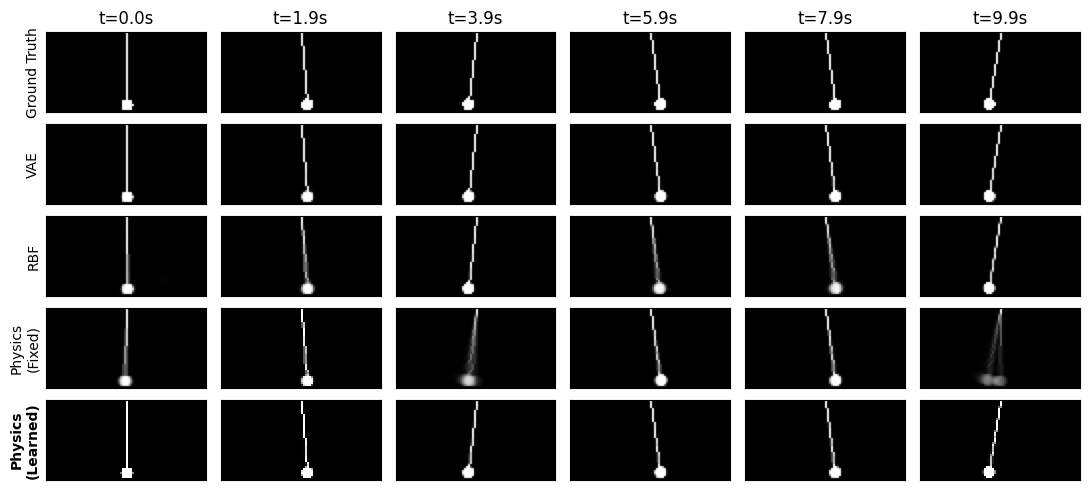

In [140]:
# Videos at 10 FPS
# data["inputs"]: tensor [b, l, w, h]

# Plot 6 frames horizontally from the first batch video
# starting from a start time to an end time

# Time range in seconds
num_frames = 6
start_t, end_t = 0.0, 9.9
indices = np.linspace(start_t*FPS, end_t*FPS, num=num_frames).astype(int)
t_at_idx = indices / FPS

variants = {
    "vae": "VAE",
    "rbf": "RBF",
    "physics": "Physics\n(Fixed)",
    "physics_scale": "Physics\n(Learned)"
}

fig, axs = plt.subplots(1 + len(by_variant), num_frames, figsize=(11, 5))

# Original Inputs
for j, ax in enumerate(axs[0]):
    data, meta = load_run(by_variant["vae"][0][0])
    ax.imshow(_to_HWT(_first_tensor_from_batch(data["inputs"]))[indices[j]], cmap="gray", vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"t={t_at_idx[j]:.1f}s")
    if j == 0:
        ax.set_ylabel("Ground Truth")

# Reconstructions
for i, variant in enumerate(variants, start=1):
    data, meta = load_run(by_variant[variant][0][0])
    for j, ax in enumerate(axs[i]):
        ax.imshow(_to_HWT(_first_tensor_from_batch(data["outputs"]["reconstructed_video"]))[indices[j]], cmap="gray", vmin=0, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(variants[variant], fontweight="bold" if variant=="physics_scale" else 1)

fig.tight_layout()
fig.savefig(f"results/pendulum_seed_{SEED}_recon.png", dpi=300, bbox_inches="tight")
fig.show()

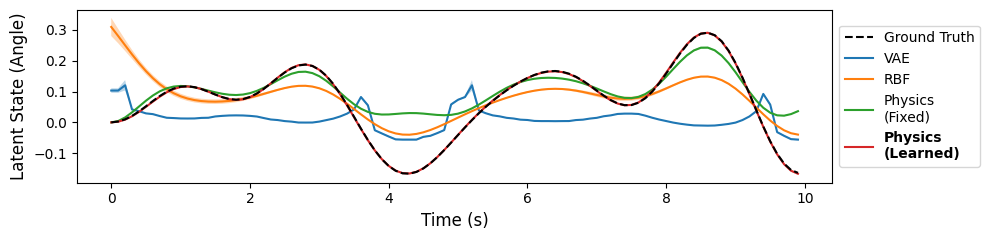

In [141]:
plt.figure(figsize=(10, 2.5))

# Load Original
data, meta = load_run(by_variant["vae"][0][0])
original = data.get("inputs")[1][0].squeeze()

# Predicted
t = np.linspace(0, 10.0, len(original), endpoint=False)
plt.plot(t, original, label="Ground Truth", color="black", linestyle="--", zorder=999)
# plt.fill_between([], [])
for i, variant in enumerate(variants, start=1):
    data, meta = load_run(by_variant[variant][0][0])
    latents = _pick_latents(data.get("outputs"))
    mean = latents.get("mean")[0].squeeze()
    std = np.sqrt(latents.get("var")[0]).squeeze()

    # Compute scale factor such that error between mean and original is minimized
    scale = torch.sum(original*mean) / torch.sum(mean**2)

    t = np.linspace(0, 10.0, len(mean), endpoint=False)
    mean = mean * scale
    std = std * scale

    plt.plot(t, mean, label=variants[variant])
    plt.fill_between(t, mean-3*std, mean+3*std, alpha=0.3, linewidth=0)

# Original


plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Latent State (Angle)", fontsize=12)
l = plt.legend(fontsize=8)

# Below plot
# l = plt.legend(fontsize=9, loc="upper center", bbox_to_anchor=(0.50, -0.265), ncol=5, frameon=False)

# To the right of plot
l = plt.legend(fontsize=10, loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=True)
l.get_texts()[-1].set_fontweight("bold") 
plt.tight_layout()
plt.savefig(f"results/pendulum_seed_{SEED}_latent.png", dpi=300, bbox_inches="tight")
plt.show()

In [143]:
SEED = 6
TASK_FILTER = "extrap"

all_pt = sorted(glob.glob(os.path.join(OUT_ROOT, "*_first_batch.pt"))) 
candidates = []
for pt in all_pt:
    meta = read_meta_for(pt)
    s = seed_from(pt, meta)
    if s is None or s != SEED:
        continue
    t = task_from(pt, meta)
    if TASK_FILTER is None or t == TASK_FILTER:
        candidates.append((pt, meta, t))

if not candidates:
    seeds_present = sorted({seed_from(p, read_meta_for(p)) for p in all_pt if seed_from(p, read_meta_for(p)) is not None})

by_variant = defaultdict(list)
for pt, meta, t in candidates:
    by_variant[variant_from(pt, meta)].append((pt, meta, t))

# move subvariant physics to its own variant
by_variant["physics_scale"] = by_variant["physics"][1:]
by_variant["physics"] = by_variant["physics"][:1]

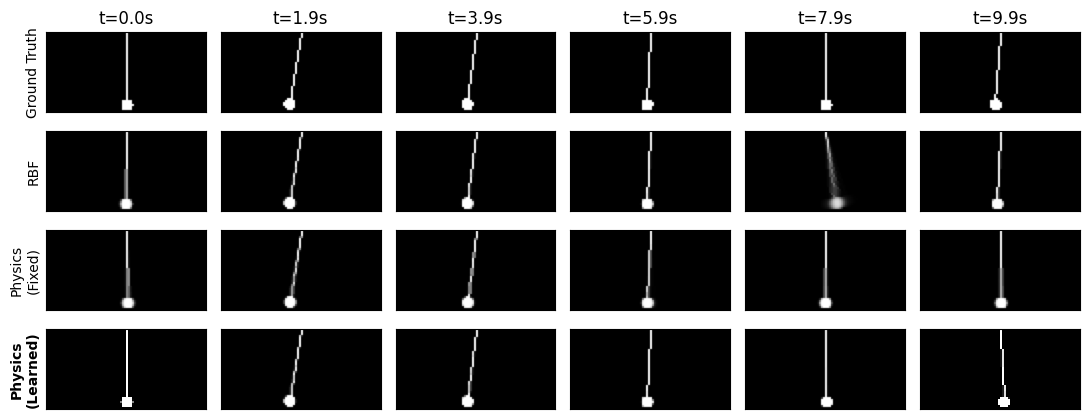

In [144]:
 # Videos at 10 FPS
# data["inputs"]: tensor [b, l, w, h]

# Plot 6 frames horizontally from the first batch video
# starting from a start time to an end time

# Time range in seconds
num_frames = 6
start_t, end_t = 0.0, 9.9
indices = np.linspace(start_t*FPS, end_t*FPS, num=num_frames).astype(int)
t_at_idx = indices / FPS

fig, axs = plt.subplots(1 + len(by_variant), num_frames, figsize=(11, 4.4))

# Original Inputs
for j, ax in enumerate(axs[0]):
    data, meta = load_run(by_variant["physics"][0][0])
    ax.imshow(_to_HWT(_first_tensor_from_batch(data["inputs"]))[indices[j]], cmap="gray", vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"t={t_at_idx[j]:.1f}s")
    if j == 0:
        ax.set_ylabel("Ground Truth")

# Reconstructions
i = 1
for variant in variants:
    if variant == "vae":
        continue
    data, meta = load_run(by_variant[variant][0][0])
    for j, ax in enumerate(axs[i]):
        ax.imshow(_to_HWT(_first_tensor_from_batch(data["outputs"]["reconstructed_video"]))[indices[j]], cmap="gray", vmin=0, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(variants[variant], fontweight="bold" if variant=="physics_scale" else 1)

    i += 1

fig.tight_layout()
fig.savefig(f"results/pendulum_seed_{SEED}_extrap.png", dpi=300, bbox_inches="tight")
fig.show()

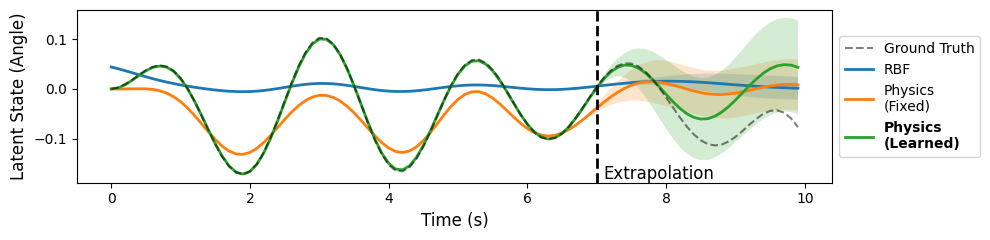

In [145]:
plt.figure(figsize=(10, 2.5))

# Original
data, meta = load_run(by_variant["physics"][0][0])
original = data.get("inputs")[1][0].squeeze()

# Predicted
# Original
t = np.linspace(0, 10.0, len(original), endpoint=False)
plt.plot(t, original, label="Ground Truth", color="black", alpha=0.5, linestyle="--", zorder=999)
for variant in variants:
    if variant == "vae":
        continue
    data, meta = load_run(by_variant[variant][0][0])
    latents = _pick_latents(data.get("outputs"))
    mean = latents.get("mean")[0].squeeze()
    std = np.sqrt(latents.get("var")[0]).squeeze()

    # Compute scale factor such that error between mean and original is minimized
    scale = torch.sum(original*mean) / torch.sum(mean**2)

    t = np.linspace(0, 10.0, len(mean), endpoint=False)
    mean = mean * scale
    std = std * scale

    plt.plot(t, mean, label=variants[variant], linewidth=2)
    plt.fill_between(t, mean-3*std, mean+3*std, alpha=0.2, linewidth=0)


# Draw verticle line 70% into the plot
plt.axvline(x=7.0, color="black", linestyle="--", linewidth=2)
y = plt.ylim()[0]
plt.text(7.0 + 0.1, y, "Extrapolation", fontsize=12, ha="left", va="bottom")


plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Latent State (Angle)", fontsize=12)
l = plt.legend(fontsize=10, loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=True)
l.get_texts()[-1].set_fontweight("bold") 
plt.tight_layout()
plt.savefig(f"results/pendulum_seed_{SEED}_extrap_latent.png", dpi=300, bbox_inches="tight")
plt.show()

In [57]:
# # For each model variant, compute the MSE of the scaled latents
# TASK_FILTER = "recon"

# mse_by_variant = {}

# for seed in [1, 2, 3, 4, 5, 6, 7]:
#     all_pt = sorted(glob.glob(os.path.join(OUT_ROOT, "*_first_batch.pt"))) 
#     candidates = []
#     for pt in all_pt:
#         meta = read_meta_for(pt)
#         s = seed_from(pt, meta)
#         if s is None or s != seed:
#             continue
#         t = task_from(pt, meta)
#         if TASK_FILTER is None or t == TASK_FILTER:
#             candidates.append((pt, meta, t))

#     if not candidates:
#         seeds_present = sorted({seed_from(p, read_meta_for(p)) for p in all_pt if seed_from(p, read_meta_for(p)) is not None})

#     by_variant = defaultdict(list)
#     for pt, meta, t in candidates:
#         by_variant[variant_from(pt, meta)].append((pt, meta, t))

#     # move subvariant physics to its own variant
#     by_variant["physics_scale"] = by_variant["physics"][1:]
#     by_variant["physics"] = by_variant["physics"][:1]

#     for variant in variants:
#         # if variant == "vae":
#         #     continue
#         if variant not in mse_by_variant:
#             mse_by_variant[variant] = []

#         data, meta = load_run(by_variant[variant][0][0])
#         original = data["inputs"][1].squeeze()
#         latents = _pick_latents(data.get("outputs"))
#         mean = latents.get("mean").squeeze()

#         # Compute scale factor such that error between mean and original is minimized
#         scale = torch.sum(original*mean, dim=1) / torch.sum(mean**2, dim=1)
#         mean = mean * scale.unsqueeze(1)

#         mse = torch.mean((original - mean)**2, dim=1)
#         rmse = torch.sqrt(mse)

#         mse_by_variant[variant].append(rmse.numpy())

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

def save_recon_gif(
    true_frames,
    recon_frames,            # e.g., RBF
    vae_frames,              # NEW
    physics_frames,
    physics_scale_frames,
    save_path="reconstruction.gif",
    fps=None,
    cmap="gray",
    title_tl="Ground Truth",
    title_tm="RBF",
    title_tr="VAE",
    title_bl="Physics",
    title_br="Physics Scale",
    dpi=120,
):
    def to_np(x):
        try:
            import torch
            if isinstance(x, torch.Tensor):
                x = x.detach().cpu().numpy()
        except Exception:
            pass
        return None if x is None else np.asarray(x)

    # Convert and squeeze optional batch dim
    stacks = []
    for arr in [true_frames, recon_frames, vae_frames, physics_frames, physics_scale_frames]:
        a = to_np(arr)
        if a is None:
            stacks.append(None); continue
        if a.ndim == 4:  # (B,T,H,W)
            a = a[0]
        assert a.ndim == 3, "Each input must be (T,H,W) or (B,T,H,W)."
        stacks.append(a)

    tf, rf, vf, pf, psf = stacks

    # frame count and fps
    T = min(x.shape[0] for x in stacks if x is not None)
    if fps is None:
        fps = 20

    # shared normalization
    vmin = float(np.nanmin([x[:T].min() for x in stacks if x is not None]))
    vmax = float(np.nanmax([x[:T].max() for x in stacks if x is not None]))

    # time vector and extrapolation index
    ts = np.linspace(0, 9.9, T)

    fig = plt.figure(figsize=(12, 6.4), dpi=dpi)

    # --- Top row: 3 panels
    gs_top = fig.add_gridspec(
        1, 3,
        top=0.9,
        bottom=0.585,   # slightly lower
        wspace=0.01
    )
    ax_tl = fig.add_subplot(gs_top[0, 0])
    ax_tm = fig.add_subplot(gs_top[0, 1])
    ax_tr = fig.add_subplot(gs_top[0, 2])
    
    # --- Bottom row: 2 panels (centered)
    gs_bottom = fig.add_gridspec(
        1, 2,
        top=0.555,      # raised closer to top row
        bottom=0.12,
        left=0.18,
        right=0.82,
        wspace=0.05
    )
    ax_bl = fig.add_subplot(gs_bottom[0, 0])
    ax_br = fig.add_subplot(gs_bottom[0, 1])
    
    plt.subplots_adjust(top=0.9, wspace=0.01)


    

    def init_ax(ax, img0, title):
        im = ax.imshow(img0, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title, fontsize=12)
        ax.set_xticks([]); ax.set_yticks([])
        return im

    im_tl = init_ax(ax_tl, tf[0], title_tl)
    im_tm = init_ax(ax_tm, rf[0], title_tm)
    im_tr = init_ax(ax_tr, vf[0], title_tr)
    im_bl = init_ax(ax_bl, pf[0], title_bl)
    im_br = init_ax(ax_br, psf[0], title_br)

    # time label (left-aligned near the first column)
    time_text = fig.text(
        0.125, 0.92, "", ha="left", va="top", fontsize=12,
        bbox=dict(facecolor="white", edgecolor="none", pad=0.25)
    )

    images = []
    for t in range(T):
        im_tl.set_data(tf[t])
        im_tm.set_data(rf[t])
        im_tr.set_data(vf[t])
        im_bl.set_data(pf[t])
        im_br.set_data(psf[t])

        time_text.set_text(f"t = {ts[t]:.2f} s")

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(h, w, 4)[..., :3]
        images.append(frame.copy())

    plt.close(fig)
    imageio.mimsave(save_path, images, fps=fps, loop=0)
    print(f"GIF saved to {save_path}")
# existing
# gt_video, rec_video (RBF)
data_gt, _ = load_run(by_variant["physics"][0][0])   # or "vae" if that’s your standard
gt_video = _to_HWT(_first_tensor_from_batch(data_gt["inputs"]))

data_vae, _ = load_run(by_variant["vae"][0][0])
vae_video = _to_HWT(_first_tensor_from_batch(data_vae["outputs"]["reconstructed_video"]))

data_phys, _ = load_run(by_variant["physics"][0][0])
phys_video = _to_HWT(_first_tensor_from_batch(data_phys["outputs"]["reconstructed_video"]))

data_phys_scale, _ = load_run(by_variant["physics_scale"][0][0])
phys_scale_video = _to_HWT(_first_tensor_from_batch(data_phys_scale["outputs"]["reconstructed_video"]))

save_recon_gif(
    true_frames=gt_video,
    recon_frames=rec_video,    
    vae_frames=vae_video,    
    physics_frames=phys_video,
    physics_scale_frames=phys_scale_video,
    save_path="pendulum_seed_9_recon.gif",
    fps=int(FPS),
    title_tl="Ground Truth",
    title_tm=variants.get("rbf", "Reconstruction"),
    title_tr="VAE",
    title_bl="Physics (Fixed)",
    title_br="Physics (Learned)",
)


GIF saved to pendulum_seed_9_recon.gif


In [146]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

def save_recon_gif(
    true_frames,
    recon_frames,
    physics_frames,
    physics_scale_frames,
    save_path="reconstruction.gif",
    fps=None,
    cmap="gray",
    title_tl="Ground Truth",
    title_tr="Reconstruction",
    title_bl="Physics",
    title_br="Physics Scale",
    dpi=120,
):
    def to_np(x):
        try:
            import torch
            if isinstance(x, torch.Tensor):
                x = x.detach().cpu().numpy()
        except Exception:
            pass
        return None if x is None else np.asarray(x)

    # to numpy + remove batch dim if present
    stacks = []
    for arr in [true_frames, recon_frames, physics_frames, physics_scale_frames]:
        a = to_np(arr)
        if a is None:
            stacks.append(None)
            continue
        if a.ndim == 4:  # (B,T,H,W) -> first in batch
            a = a[0]
        assert a.ndim == 3, "Each input must be (T,H,W) or (B,T,H,W)."
        stacks.append(a)

    tf, rf, pf, psf = stacks

    # frames count = min across provided stacks
    T = min(x.shape[0] for x in stacks if x is not None)
    if fps is None:
        fps = 20

    # shared normalization over all provided stacks
    mins = [x[:T].min() for x in stacks if x is not None]
    maxs = [x[:T].max() for x in stacks if x is not None]
    vmin = float(np.nanmin(mins))
    vmax = float(np.nanmax(maxs))

    # time vector 0 → 9.9 s
    ts = np.linspace(0, 9.9, T)
    extrap_time = 6.93
    extrap_idx = int(np.argmin(np.abs(ts - extrap_time)))

    # 2x2 grid, larger panels
    fig, axes = plt.subplots(2, 2, figsize=(10.5, 8.0), dpi=dpi, constrained_layout=False)
    (ax_tl, ax_tr), (ax_bl, ax_br) = axes

    # helper to init an axis
    def init_ax(ax, img0, title):
        im = ax.imshow(img0, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title, fontsize=12)
        ax.set_xticks([]); ax.set_yticks([])
        return im

    im_tl = init_ax(ax_tl, tf[0], title_tl)
    im_tr = init_ax(ax_tr, rf[0], title_tr)
    im_bl = init_ax(ax_bl, pf[0], title_bl)
    im_br = init_ax(ax_br, psf[0], title_br)

    # centered time label, tight to the panels
    time_text = fig.text(
        0.125, 0.87, "", ha="left", va="top", fontsize=12,
        bbox=dict(facecolor="white", edgecolor="none", pad=0.25)
    )

    extrap_text = fig.text(
        0.5, 0.87, "", ha="center", va="top", fontsize=11, color="black",
        bbox=dict(facecolor="white", edgecolor="none", pad=0.2)
    )

    # reduce top margin so text is closer to images
    plt.subplots_adjust(top=0.9, wspace=0.01, hspace=-0.2)

    images = []
    for t in range(T):
        im_tl.set_data(tf[t])
        im_tr.set_data(rf[t])
        im_bl.set_data(pf[t])
        im_br.set_data(psf[t])

        time_text.set_text(f"t = {ts[t]:.2f} s")
        if t >= extrap_idx:
            extrap_text.set_text("Extrapolation")
        else:
            extrap_text.set_text("")

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(h, w, 4)[..., :3]
        images.append(frame.copy())

    plt.close(fig)
    imageio.mimsave(save_path, images, fps=fps, loop=0)
    print(f"GIF saved to {save_path}")

data_gt, _ = load_run(by_variant["physics"][0][0])   # or "vae" if that’s your standard
gt_video = _to_HWT(_first_tensor_from_batch(data_gt["inputs"])) 
data_phys, _ = load_run(by_variant["physics"][0][0])
phys_video = _to_HWT(_first_tensor_from_batch(data_phys["outputs"]["reconstructed_video"]))

data_phys_scale, _ = load_run(by_variant["physics_scale"][0][0])  # adjust key if different
phys_scale_video = _to_HWT(_first_tensor_from_batch(data_phys_scale["outputs"]["reconstructed_video"]))

save_recon_gif(
    true_frames=gt_video,
    recon_frames=rec_video,
    physics_frames=phys_video,
    physics_scale_frames=phys_scale_video,
    save_path="pendulum_seed_9_extrap.gif",
    fps=int(FPS),
    title_tl="Ground Truth",
    title_tr=variants.get("rbf", "Reconstruction"),
    title_bl="Physics (Fixed)",
    title_br="Physics (Learned)",
)


GIF saved to pendulum_seed_9_extrap.gif


In [11]:
rows = []
for variant in variants:
    # if variant == "vae":
    #     continue
    # Print mean MSE +- 95% CI
    mses = np.array(mse_by_variant[variant]) # (n_runs, n_timesteps)
    means = np.mean(mses, axis=1)
    mean = np.mean(means)
    ci = 1.96 * np.std(means) / np.sqrt(len(means))

    upper = mean + ci
    lower = mean - ci

    rows.append((f"{variants[variant]}", f"{mean:.5f} ± {ci:.5f}"))

df = pd.DataFrame(rows, columns=["Model", "RMSE"])
df.to_csv(f"results/seed_{SEED}_extrap_mse.csv", index=False)
print(df.to_latex(index=False))
df

\begin{tabular}{ll}
\toprule
Model & RMSE \\
\midrule
VAE & 0.08567 ± 0.02109 \\
RBF & 0.06605 ± 0.00833 \\
Physics
(Fixed) & 0.04409 ± 0.02775 \\
Physics
(Learned) & 0.01452 ± 0.02265 \\
\bottomrule
\end{tabular}



,Model,RMSE
0,VAE,0.08567 ± 0.02109
1,RBF,0.06605 ± 0.00833
2,Physics\n(Fixed),0.04409 ± 0.02775
3,Physics\n(Learned),0.01452 ± 0.02265


In [12]:
TASK_FILTER = "recon"

mse_by_variant = {}
freq_list = []
damp_list = []

for seed in [1, 2, 3, 4, 5, 6, 7]:
    all_pt = sorted(glob.glob(os.path.join(OUT_ROOT, "*_first_batch.pt"))) 
    candidates = []
    for pt in all_pt:
        meta = read_meta_for(pt)
        s = seed_from(pt, meta)
        if s is None or s != seed:
            continue
        t = task_from(pt, meta)
        if TASK_FILTER is None or t == TASK_FILTER:
            candidates.append((pt, meta, t))

    if not candidates:
        seeds_present = sorted({seed_from(p, read_meta_for(p)) for p in all_pt if seed_from(p, read_meta_for(p)) is not None})

    by_variant = defaultdict(list)
    for pt, meta, t in candidates:
        by_variant[variant_from(pt, meta)].append((pt, meta, t))

    by_variant["physics_scale"] = by_variant["physics"][1:]
    by_variant["physics"] = by_variant["physics"][:1]

    variant = "physics_scale"
    if variant not in mse_by_variant:
        mse_by_variant[variant] = []

    data, meta = load_run(by_variant[variant][0][0])
    freq_list.append(data.get("outputs")["frequency"])
    damp_list.append(data.get("outputs")["damping"])


original_freq = 3.13
original_damp = 0.07
mse_freq = np.mean((original_freq - np.array(freq_list))**2)
mse_damp = np.mean((original_damp - np.array(damp_list))**2)

rmse_freq = np.sqrt(mse_freq)
rmse_damp = np.sqrt(mse_damp)


# mse_by_variant[variant].append(rmse.numpy())

In [13]:
df = pd.DataFrame([
    ["Frequency", 3.130, f"{np.mean(freq_list):.3f}", f"{rmse_freq:.3f}"], 
    ["Damping", 0.079, f"{np.mean(damp_list):.3f}", f"{rmse_damp:.3f}"]
    ], columns=["Parameter", "Ground Truth", "Mean Learned Value", "RMSE"])
print(df.to_latex(index=False))
df

\begin{tabular}{lrll}
\toprule
Parameter & Ground Truth & Mean Learned Value & RMSE \\
\midrule
Frequency & 3.130000 & 2.704 & 0.475 \\
Damping & 0.079000 & 0.055 & 0.018 \\
\bottomrule
\end{tabular}



,Parameter,Ground Truth,Mean Learned Value,RMSE
0,Frequency,3.130,2.704,0.475
1,Damping,0.079,0.055,0.018


In [275]:
freq_list

[tensor(2.6186, dtype=torch.float64),
 tensor(2.6171, dtype=torch.float64),
 tensor(2.5984, dtype=torch.float64),
 tensor(3.2193, dtype=torch.float64),
 tensor(2.6246, dtype=torch.float64),
 tensor(2.6190, dtype=torch.float64),
 tensor(2.6318, dtype=torch.float64)]

In [233]:
damp_list

[tensor(0.0505, dtype=torch.float64),
 tensor(0.0513, dtype=torch.float64),
 tensor(0.0507, dtype=torch.float64),
 tensor(0.0769, dtype=torch.float64),
 tensor(0.0507, dtype=torch.float64),
 tensor(0.0522, dtype=torch.float64),
 tensor(0.0519, dtype=torch.float64)]

In [276]:
TASK_FILTER = "extrap"

mse_by_variant = {}
freq_list = []
damp_list = []

for seed in [1, 3, 5, 7]:
    all_pt = sorted(glob.glob(os.path.join(OUT_ROOT, "*_first_batch.pt"))) 
    candidates = []
    for pt in all_pt:
        meta = read_meta_for(pt)
        s = seed_from(pt, meta)
        if s is None or s != seed:
            continue
        t = task_from(pt, meta)
        if TASK_FILTER is None or t == TASK_FILTER:
            candidates.append((pt, meta, t))

    if not candidates:
        seeds_present = sorted({seed_from(p, read_meta_for(p)) for p in all_pt if seed_from(p, read_meta_for(p)) is not None})

    by_variant = defaultdict(list)
    for pt, meta, t in candidates:
        by_variant[variant_from(pt, meta)].append((pt, meta, t))

    by_variant["physics_scale"] = by_variant["physics"][1:]
    by_variant["physics"] = by_variant["physics"][:1]

    variant = "physics_scale"
    if variant not in mse_by_variant:
        mse_by_variant[variant] = []

    data, meta = load_run(by_variant[variant][0][0])
    freq_list.append(data.get("outputs")["frequency"])
    damp_list.append(data.get("outputs")["damping"])


original_freq = 3.13
original_damp = 0.07
mse_freq = np.mean((original_freq - np.array(freq_list))**2)
mse_damp = np.mean((original_damp - np.array(damp_list))**2)

rmse_freq = np.sqrt(mse_freq)
rmse_damp = np.sqrt(mse_damp)


# mse_by_variant[variant].append(rmse.numpy())

In [277]:
rmse_freq

0.4689661377138857

In [278]:
rmse_damp

0.006496382944095561

In [279]:
df = pd.DataFrame([
    ["Frequency", 3.130, f"{np.mean(freq_list):.3f}", f"{rmse_freq:.3f}"], 
    ["Damping", 0.079, f"{np.mean(damp_list):.3f}", f"{rmse_damp:.3f}"]
    ], columns=["Parameter", "Ground Truth", "Mean Learned Value", "RMSE"])
print(df.to_latex(index=False))
df

\begin{tabular}{lrll}
\toprule
Parameter & Ground Truth & Mean Learned Value & RMSE \\
\midrule
Frequency & 3.130000 & 2.909 & 0.469 \\
Damping & 0.079000 & 0.064 & 0.006 \\
\bottomrule
\end{tabular}



,Parameter,Ground Truth,Mean Learned Value,RMSE
0,Frequency,3.130,2.909,0.469
1,Damping,0.079,0.064,0.006


In [237]:
rows = []
variant = "physics_scale"
mses = np.array(mse_by_variant[variant]) # (n_runs, n_timesteps)
means = np.mean(mses, axis=1)
mean = np.mean(means)
ci = 1.96 * np.std(means) / np.sqrt(len(means))

upper = mean + ci
lower = mean - ci

rows.append((f"{variants[variant]}", f"{mean:.5f} ± {ci:.5f}"))

df = pd.DataFrame(rows, columns=["Model", "RMSE"])
df.to_csv(f"results/seed_{SEED}_extrap_mse.csv", index=False)
print(df.to_latex(index=False))
df

AxisError: axis 1 is out of bounds for array of dimension 1